In [31]:
# %pip install pyyaml opencv-python matplotlib numpy scipy -i https://pypi.tuna.tsinghua.edu.cn/simple

# 模板处理

In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

## 参数读入

In [33]:
# 数据集：
# 'source/1.1'
# 'source/1.2' 不推荐使用 没有正常的模板
# 'source/1.3'

source_path = 'source/1.1'
config_file_path = os.path.join(source_path, 'config.yaml')

# 待测图像
path_to_test = 'source/1.1/img/tv201712271646576FW62O.jpg'


数据集格式：
```plain
source/dataset/
- img/ # 待测图片
    - xxx1.jpg
    - xxx2.jpg
    - ...
- template.jpg # 模板图
- config.yaml # 参数

```

In [34]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.1/template2.jpg
Candidate Points: [[700, 766], [624, 659], [603, 528], [647, 403], [745, 311], [851, 276], [981, 292], [1086, 361], [1152, 472], [1160, 601], [1107, 720]]

Zone Point: [970, 362]
Zone Radius: 15
Zone Theta: 10
Valid Threshold: 70
step 5
Start Point: -0.1
End Point: 0.9
Precision: 2
Unit: MPa


debug用的函数

In [35]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(12, 12))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

模板图片需要尽量正面

如果质量不好，建议直接将非表盘必要的内容进行屏蔽（PhotoShop）操作一下

In [36]:
# 模板读取
image = cv2.imread(image_path)
candidate_point = np.array(candidate_point)

(1080, 1920, 3)


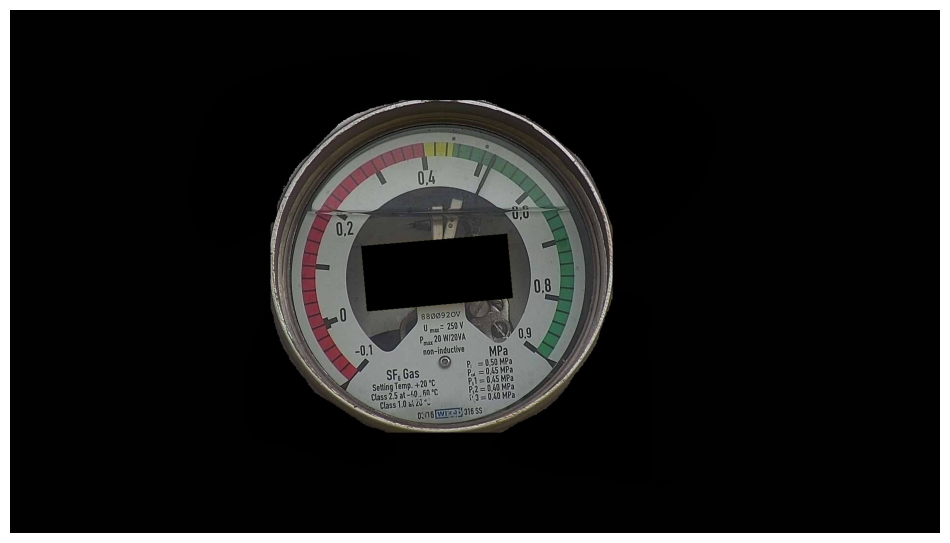

In [37]:
# debug
print(image.shape)
show_img(image)

## 椭圆拟合

In [38]:
from scipy.optimize import least_squares
import numpy as np

def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    distance_to_focus_1 = np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2)
    distance_to_focus_2 = np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)

    # Return the difference between actual and target distances for each point
    return distance_to_focus_1 + distance_to_focus_2 - sum_of_target_distance

def fit_ellipse(x_samples, y_samples):

    # Compute the centroid of the samples
    centroid_x = np.mean(x_samples)
    centroid_y = np.mean(y_samples)

    # Find the point farthest from the centroid
    distances_from_centroid = np.sqrt((x_samples - centroid_x) ** 2 + (y_samples - centroid_y) ** 2)
    max_distance_index = np.argmax(distances_from_centroid)
    far_point_x = x_samples[max_distance_index]
    far_point_y = y_samples[max_distance_index]

    # Initial guess for the second focus
    x_focus_2_init = far_point_x
    y_focus_2_init = far_point_y

    # Estimate the sum of distances from any point on the ellipse to the foci
    sum_of_target_distance_init = 2 * distances_from_centroid[max_distance_index]

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([centroid_x, centroid_y, x_focus_2_init, y_focus_2_init, sum_of_target_distance_init])
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt(a_res**2 - (l_ab / 2)**2)  # Semi-minor axis length

        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:
        print('Fail to fit ellipse')
        return None


# (x, y) rotate around (h,k) with alpha 
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot
def get_Point_in_ellipse(a, b, theta):
    return a * np.cos(theta) , b * np.sin(theta)

def Point_in_ellipse(h, k, a, b, alpha, theta):
    x0, y0 = np.cos(theta), np.sin(theta)
    x_real_rot, y_real_rot = rotate(x0, y0, -alpha)
    x_real_rot, y_real_rot = get_Point_in_ellipse(a, b, np.arctan2(y_real_rot, x_real_rot))
    x_res, y_res = rotate(x_real_rot, y_real_rot, alpha)
    return x_res + h, y_res + k

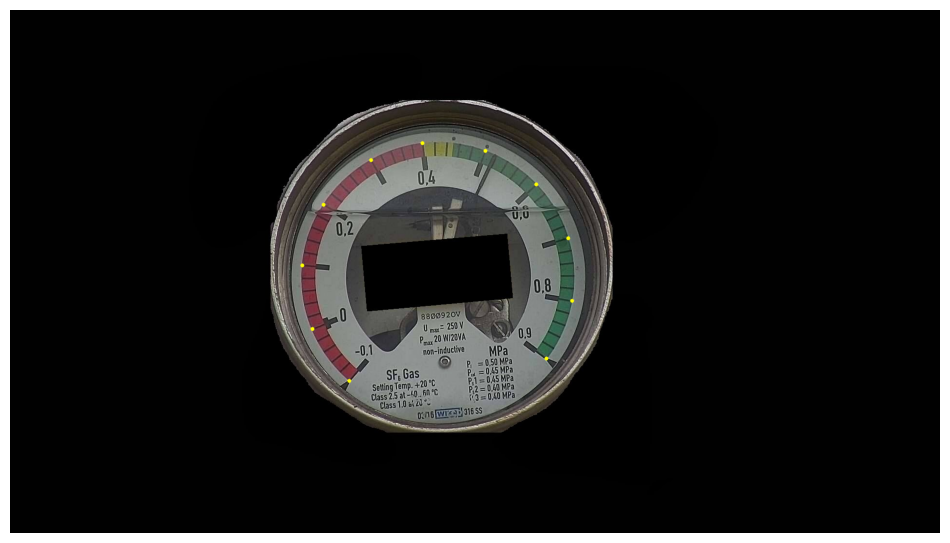

In [39]:
# 拟合过程前转换为直角坐标系（图像坐标系下的y是反的）
x_samples = candidate_point.T[0]
y_samples = image.shape[1] - candidate_point.T[1]
show_point(image, x_samples, y_samples)

In [40]:
# 求解a_res, b_res, x0, y0, alpha_res
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_samples, y_samples)

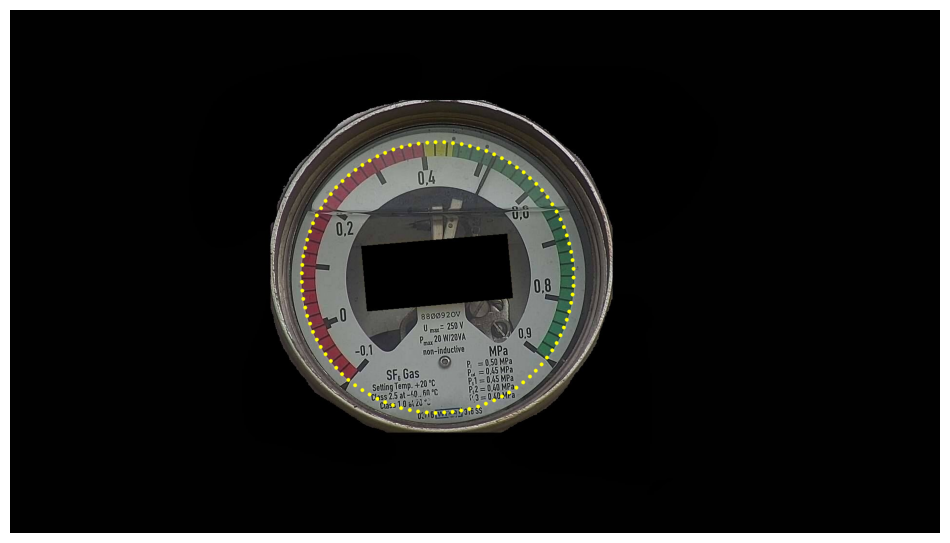

In [41]:
# debug

theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_res, y_res = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(image, x_res, y_res)


# 这里只显示椭圆形状 点准不准没有意义

根据zone_point绘制扫描区域

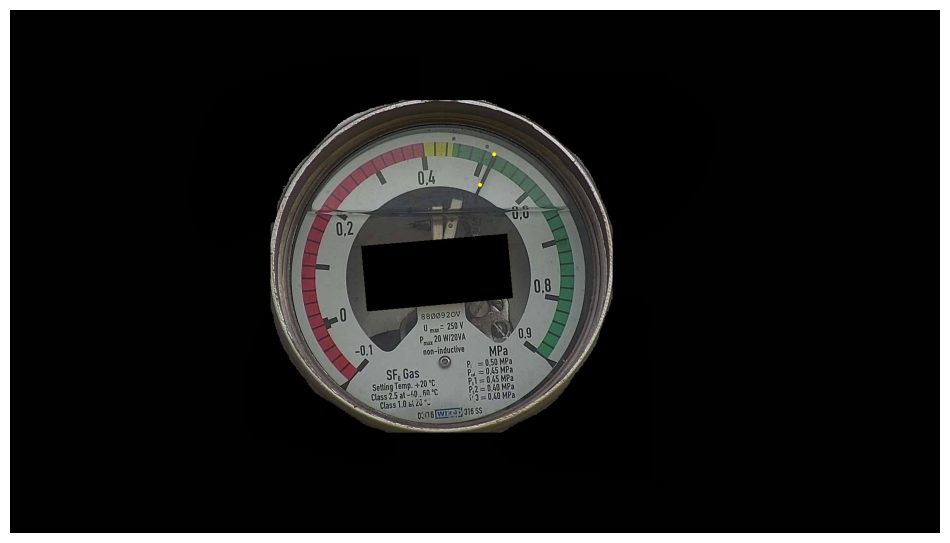

In [42]:
zone_point_x = zone_point[0]
zone_point_y = image.shape[1] - zone_point[1]

# 求出方向向量上在椭圆的坐标点
theta_zone_point_in_ellipse = np.arctan2(zone_point_y - y0, zone_point_x - x0)
point_in_ellipse_x, point_in_ellipse_y = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_zone_point_in_ellipse)

show_point( image, [point_in_ellipse_x, zone_point_x], [point_in_ellipse_y, zone_point_y] )

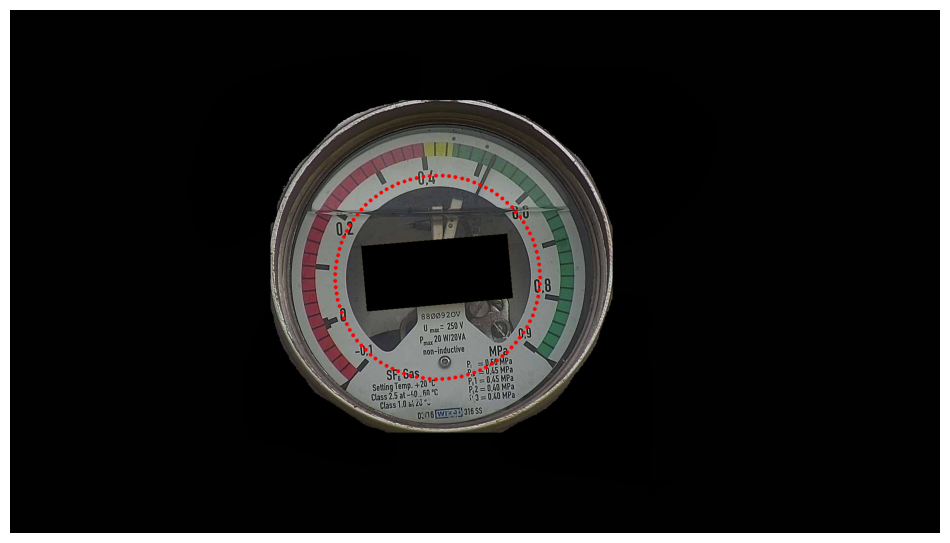

In [43]:
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([point_in_ellipse_x, point_in_ellipse_y]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域 中线的椭圆
theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_zone, y_zone = Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_res)
show_point(image, x_zone, y_zone, (0,0,255))

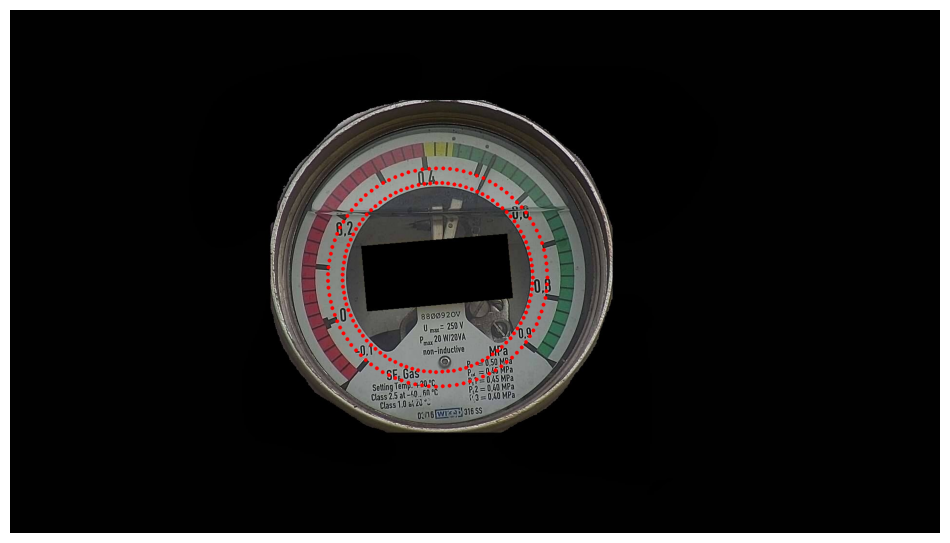

In [44]:
# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(image, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

## 计算刻度点坐标

In [45]:
# np.arctan2(y,x) 使用arctan2求弧度制夹角
# 第一象限 0 -> pi/2 （逆时针）
# 第二象限 pi/2 -> pi
# 第三象限 -pi -> -pi/2
# 第四象限 -pi/2 -> 0

# 刻度s到刻度t间 切分成separate_num份
# 返回左闭右开的点集序列
def separate_point(s_point, t_point, separate_num, keep_last_point=False):

    s_point_x, s_point_y = s_point[0], s_point[1]
    t_point_x, t_point_y = t_point[0], t_point[1]

    # # 两个相邻标点不应该超过90度
    theta_s = np.arctan2(s_point_y - y0, s_point_x - x0)
    theta_t = np.arctan2(t_point_y - y0, t_point_x - x0)
    # print(theta_s, theta_t)

    if theta_s < theta_t: theta_s += np.pi * 2 # 负角度

    # 切分出separate_num + 1个点
    theta_small_point = np.linspace(theta_s, theta_t, separate_num + 1)
    x_small, y_small = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_small_point)


    if not keep_last_point:
        x_small = x_small[:-1]
        y_small = y_small[:-1]
    # 预览
    return x_small, y_small

第一次求解需要求解较小的、未标注出来的刻度点

定义x_samples、y_samples是从起点刻度到终点刻度，按顺时针方向排序的大刻度集合

若效果一般 应该标注所有刻度点（大小都标）并且跳过第一次求解

In [46]:
samples_num = len(x_samples)
x_samples_sep1, y_samples_sep1 = [], []

for i in range(1, samples_num):

    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])

    x_res, y_res = separate_point(s_point, t_point, step, i == samples_num - 1 )
    x_samples_sep1.extend( x_res )
    y_samples_sep1.extend( y_res )


x_samples_sep1 = np.array(x_samples_sep1)
y_samples_sep1 = np.array(y_samples_sep1)

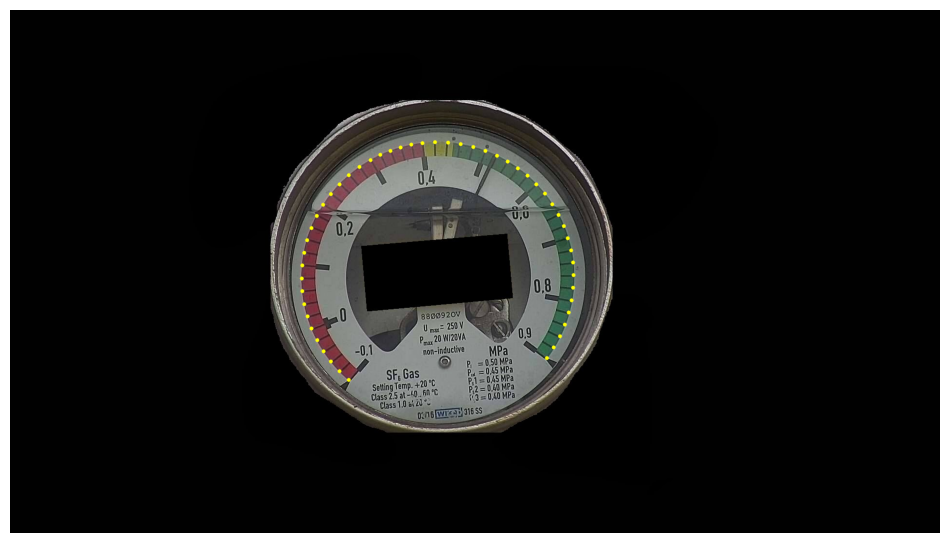

In [47]:
x_samples, y_samples = x_samples_sep1, y_samples_sep1
show_point(image, x_samples, y_samples)

第二次求解需要求出估读部分的刻度点

一般默认把所有刻度点之间切分10份

由于后续读数算法的要求 我们需要在首尾各增加一个新刻度

保证每个需要进行读数的刻度前后都有10个刻度 用于计算切线


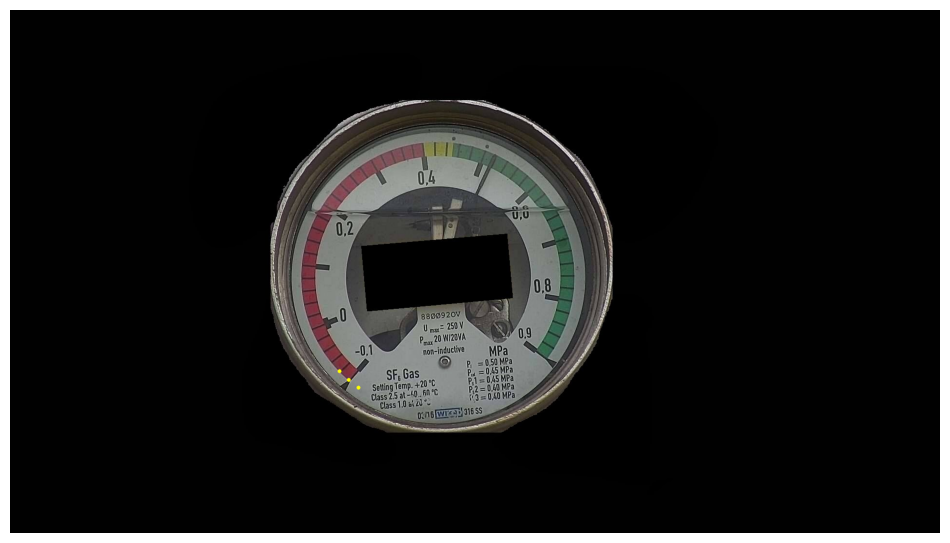

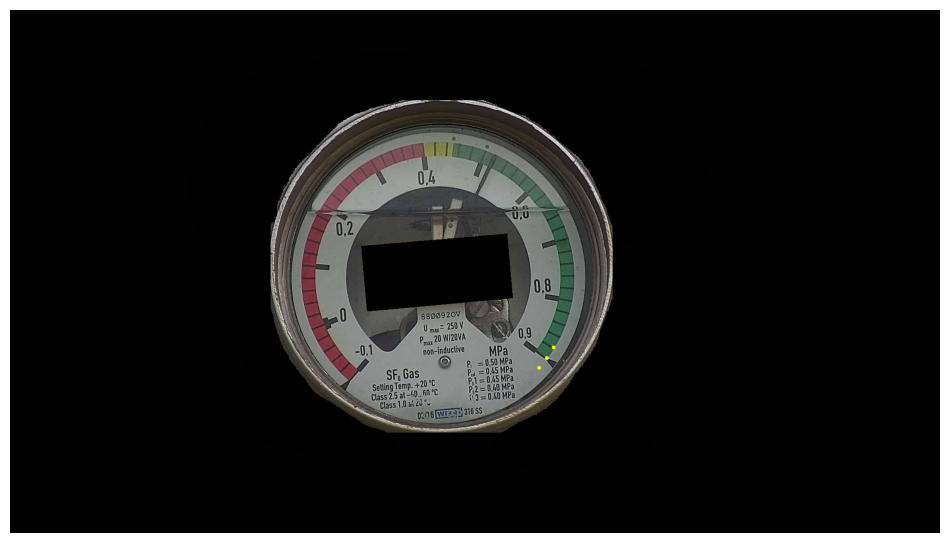

In [48]:
# 起点方向点
theta_s = np.arctan2(y_samples[0] - y0, x_samples[0] - x0) # 第一个点
theta_t = np.arctan2(y_samples[1] - y0, x_samples[1] - x0) # 第二个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_s - theta_t # theta_s是中点夹角

point_newx, point_newy = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx,x_samples[:2])), np.concatenate((point_newy, y_samples[:2])))

## 添加到最前面
x_samples = np.concatenate((point_newx, x_samples))
y_samples = np.concatenate((point_newy, y_samples))

# 终点方向点
theta_s = np.arctan2(y_samples[-2] - y0, x_samples[-2] - x0) # 倒数第二个点
theta_t = np.arctan2(y_samples[-1] - y0, x_samples[-1] - x0) # 倒数第一个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_t - theta_s # theta_t是中点夹角

point_newx, point_newy = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx, x_samples[-2:])),  np.concatenate((point_newy,y_samples[-2:])) )

## 添加到最后面
x_samples = np.concatenate((x_samples, point_newx))
y_samples = np.concatenate((y_samples, point_newy))

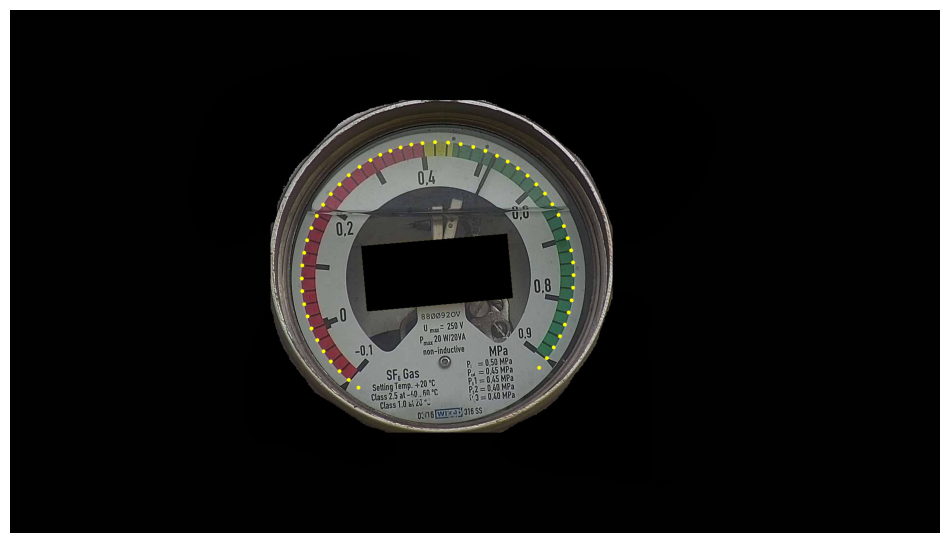

In [49]:
show_point(image, x_samples, y_samples)

In [50]:
# 切分估读区域
samples_num = len(x_samples)
x_samples_sep2, y_samples_sep2 = [], []

for i in range(1, samples_num):

    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])

    x_res, y_res = separate_point(s_point, t_point, 10, keep_last_point= (i == samples_num - 1))
    x_samples_sep2.extend( x_res )
    y_samples_sep2.extend( y_res )

x_samples_sep2 = np.array(x_samples_sep2)
y_samples_sep2 = np.array(y_samples_sep2)

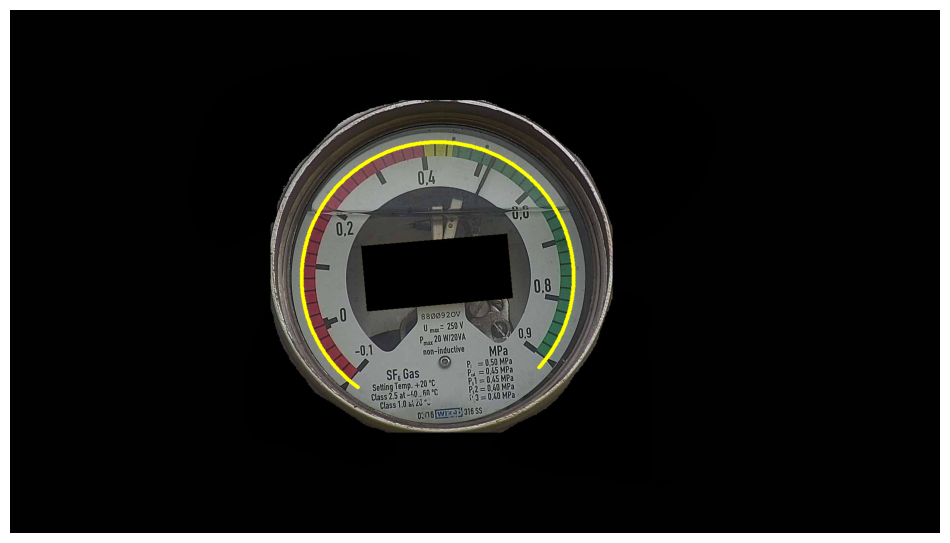

In [51]:
x_samples, y_samples = x_samples_sep2, y_samples_sep2
show_point(image, x_samples, y_samples)

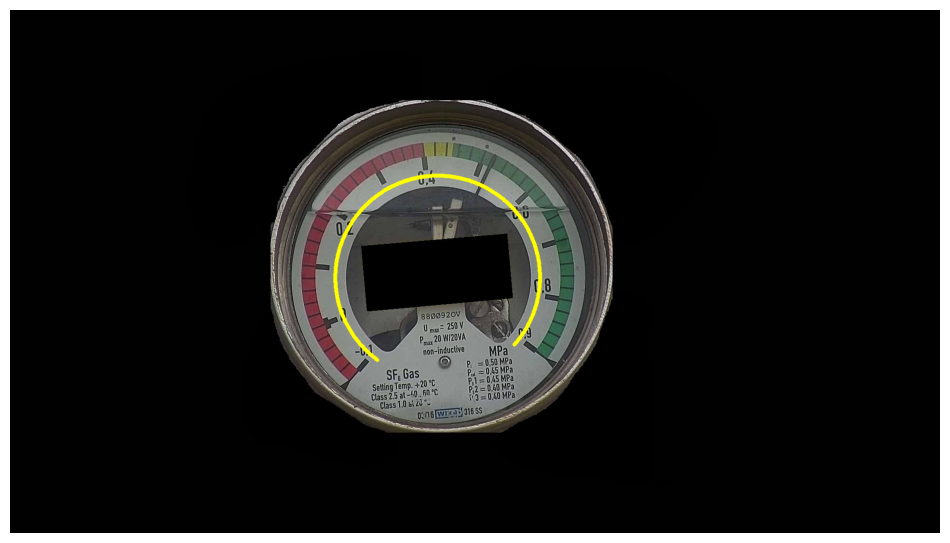

总共刻度点数 = 521


In [52]:
# 接下来把点集移动到扫描区域中线即可
theta_samples = [
    np.arctan2(y_samples[i] - y0, x_samples[i] - x0)
    for i in range(len(x_samples))
]
x_res, y_res = Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_samples)
show_point(image, x_res, y_res)
print(f'总共刻度点数 = {len(x_res)}')

# 转换回图片坐标 得到模板点
template_point = np.array([x_res, image.shape[1] - y_res]).T

# 模板匹配

In [53]:
# 绘制线段
def draw_segment(gray_img, x1, y1, x2, y2):
    color_image = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    for (x_s, y_s, x_t, y_t) in zip(x1, y1, x2, y2):
        cv2.line(color_image, (x_s, y_s), (x_t, y_t), (0, 0, 255), thickness=5)

    show_img(color_image)

SIFT求解单应矩阵

In [54]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [55]:
# 将模板点的点集透视变化到目标图中
def transform_template(template_point, img1, img2, debug):

    # 求解单应
    H = SIFT4H(img1, img2, debug)
    if H is None: return None

    template_projected_points = cv2.perspectiveTransform(template_point.reshape(-1,1,2), H)
    return template_projected_points.reshape(-1,2)

## 指针扫描

In [56]:
'''
首先需要求解每个刻度点对应位置的切线

将左右连续10个点对应进行连线，其连线的斜率均值作为切线

即可求出与指针齐平的刻度线
'''

def avg_alpha(points):

    points_num = len(points)
    alpha = [0 for i in range(points_num - 20)]

    for i in range(10, points_num - 10):

        # 累加左右10个点
        sum_k, cnt_empty = 0, 0
        for j in range(1,10 + 1):

            delta_y = points[i+j][1] - points[i-j][1]
            delta_x = points[i+j][0] - points[i-j][0]

            # 记录斜率不存在的情况
            if np.fabs(delta_x) < 1e-6: cnt_empty += 1
            else: sum_k += delta_y / delta_x

        # 斜率不存在的情况较多 直接设为0
        if cnt_empty > 5 : alpha[i - 10] = 0.0
        else:
            k_i =  sum_k / ( 10 - cnt_empty )
            if np.fabs(k_i) < 1e-6 : alpha[i - 10] = 90.0
            else: alpha[i - 10] = np.arctan(-1 / k_i) * 180 / np.pi
    return np.radians(alpha)

In [57]:
def binarize_image(gray_image):
    """
    将灰度图像进行二值化处理，超过阈值的像素值设为255，小于阈值的设为0。

    返回:
    - 二值化后的图像
    """
    ret, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

# 叉积
def cross(x1,y1,x2,y2):
    return x1 * y2 - x2 * y1

# 精度误差
def sgn(x):
    if np.fabs(x) < 1e-6: return 0
    return 1 if x > 0 else -1



In [58]:
# 扫描环形区域 求解指针位置
def scanning(template_projected_points, alpha_points, res_img, debug=False):

    res_i, min_pixel = 0, 1e9 # 答案刻度点及像素均值
    debug_img = res_img.copy()

    for i in range(0,len(alpha_points)):

        x = template_projected_points[i+10][0]
        y = template_projected_points[i+10][1]

        vec1_x = np.cos(alpha_points[i] + zone_theta)
        vec1_y = np.sin(alpha_points[i] + zone_theta)

        vec2_x = np.cos(alpha_points[i] - zone_theta)
        vec2_y = np.sin(alpha_points[i] - zone_theta)

        # 用矩形区域框出
        x_min, x_max, y_min, y_max = int(x - zone_radius), int(x + zone_radius), int(y - zone_radius), int(y + zone_radius)
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, res_img.shape[1])
        y_max = min(y_max, res_img.shape[0])

        sum_pixel = 0.0
        cnt_inside_pixel = 0

        for ty in range(y_min, y_max):
            for tx in range(x_min, x_max):
                vx, vy = tx - x, ty - y

                # 超出扇形半径
                if vx ** 2 + vy **2 > (zone_radius) ** 2: continue

                # 位于两个扇形内
                if sgn( cross(vec1_x, vec1_y, vx, vy) ) * sgn( cross(vec2_x, vec2_y, vx, vy) ) <= 0:

                    if i % 20 == 0: debug_img[ty, tx] = 0
                    sum_pixel += res_img[ty,tx]
                    cnt_inside_pixel += 1

                    if sum_pixel < 0: print('assert')

        if cnt_inside_pixel > valid_threshold  and sum_pixel/cnt_inside_pixel < min_pixel:
            min_pixel = sum_pixel/cnt_inside_pixel
            res_i = i

    if debug: show_img(debug_img)
    return res_i


In [59]:
 def process_img(template_img, path, template_point, debug=True):

    # 准备模板和待测图
    img1 = template_img.copy()
    img2 = cv2.imread(path)

    # 透视变化模板标注点
    template_projected_points = transform_template(template_point, image, img2, debug)
    if debug:
        show_point(img2, template_projected_points.T[0], template_projected_points.T[1], reversed=False)

    # 求解斜率
    alpha_points = avg_alpha(template_projected_points)

    # 求解指针需要使用灰度图像
    gray_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # 根据之前求出的分界进行二值化
    gray_img = binarize_image(gray_img)
    if debug: show_img(gray_img)


    # 求出所有刻度点的刻度线线段
    x_start = [ 
        int(template_projected_points[i + 10][0] - zone_radius * np.cos(alpha_points[i])) 
        for i in range(len(alpha_points)) 
    ]
    y_start = [
        int(template_projected_points[i + 10][1] - zone_radius * np.sin(alpha_points[i]))
        for i in range(len(alpha_points))
    ]
    x_end = [
        int(template_projected_points[i + 10][0] + zone_radius * np.cos(alpha_points[i]))
        for i in range(len(alpha_points))
    ]
    y_end = [
        int(template_projected_points[i + 10][1] + zone_radius * np.sin(alpha_points[i]))
        for i in range(len(alpha_points))
    ]


    # 展示一部分
    if debug:
        draw_segment(gray_img, x_start[::10], y_start[::10], x_end[::10], y_end[::10])

    res_i = scanning(template_projected_points, alpha_points, gray_img, debug=debug)

    # 标注指针
    if debug:
        draw_segment(gray_img, [x_start[res_i]], [y_start[res_i]], [x_end[res_i]], [y_end[res_i]])

    P = ( res_i / (len(alpha_points) - 1) ) * (END_POINT - START_POINT) + START_POINT
    print(f'读数 = {round(P, PRESICISION)}{UNIT} P = {P}')


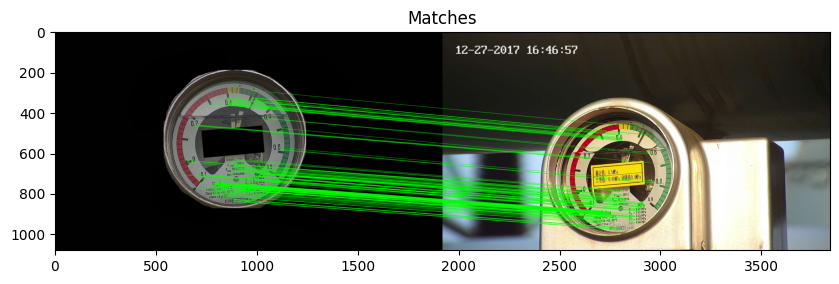

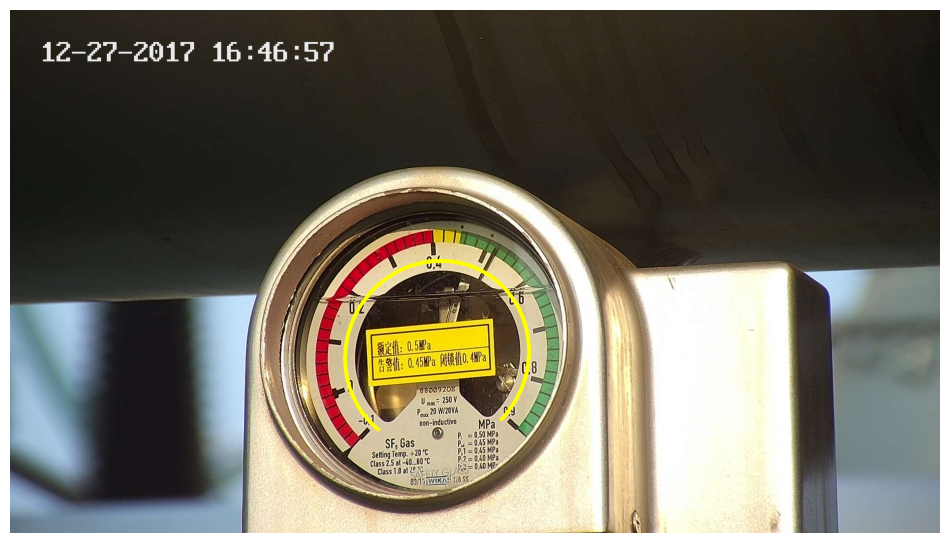

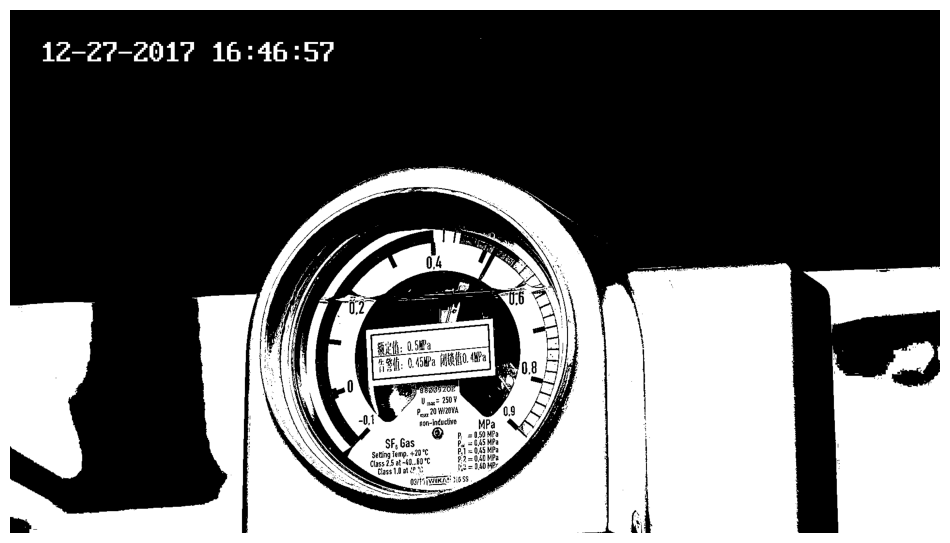

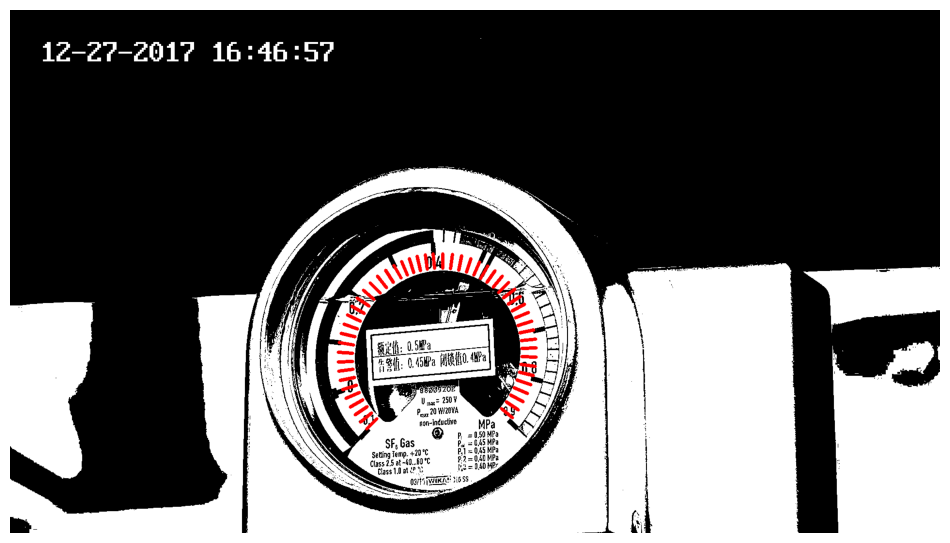

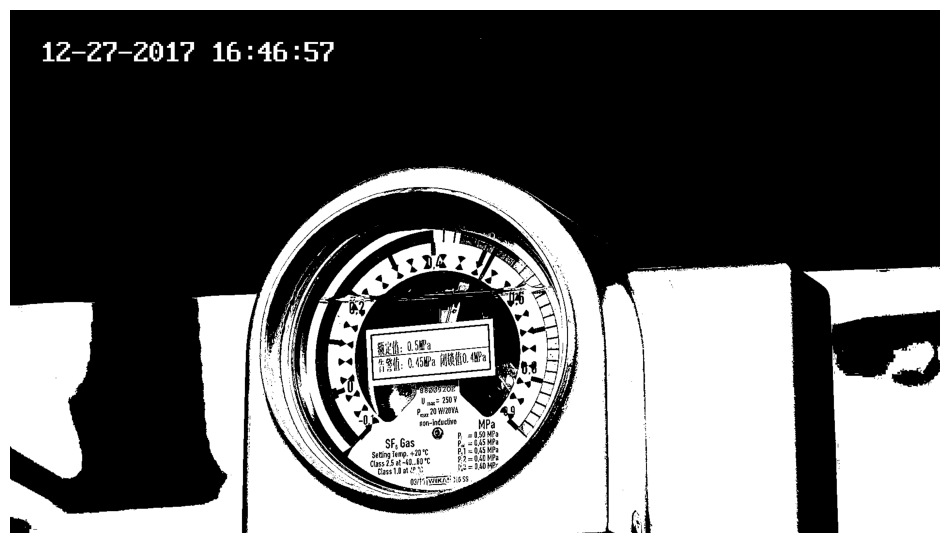

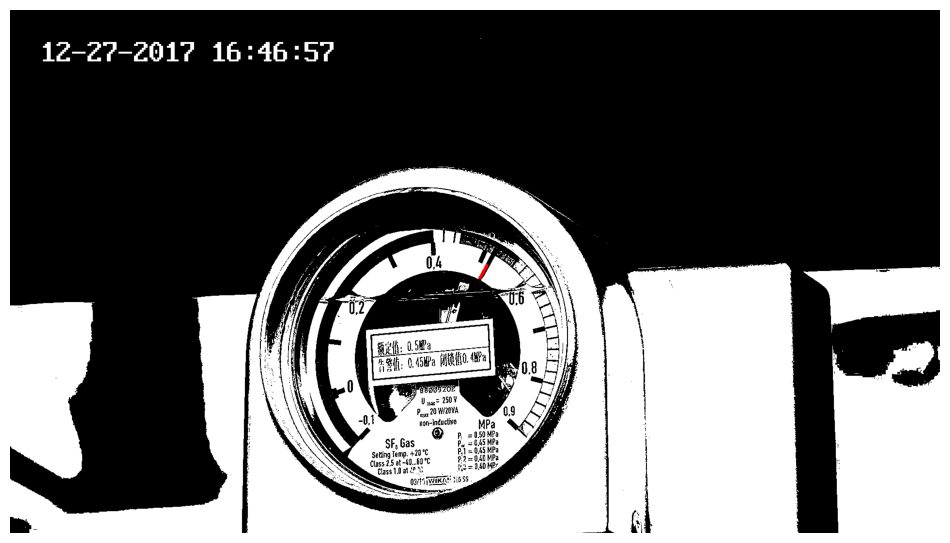

读数 = 0.52MPa P = 0.518


In [60]:

template_img = cv2.imread(image_path)
process_img(template_img, path_to_test, template_point)